
**Initialization**

In [67]:
import seaborn as sns
import os
import networkx as nx
from pprint import pprint
import pandas as pd
import numpy as np
import random
import math as m
import glob
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
from grave import plot_network
basedir = '../results'

def giant_component(g: nx.Graph) -> nx.Graph:
    return nx.subgraph(g, max(nx.connected_components(g), key=len))

from scipy.stats import t
def ci(series):
    return series.sem()*t.ppf((1 + 0.95) / 2., len(series)-1)

def to_csv_comment(df, path):
    with open(path, 'w') as fr:
        fr.write('#'+df.to_csv())

/tmp/ipykernel_2294643/1883393054.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


**Read Data**

In [162]:
##Read all the graphs
import re
# re.split('; |, |\*|\n',a)
graphs = []
#
files = glob.glob(f'{basedir}/*/*.wireless.graphml.gz')

for f in files:
    w_g = nx.read_graphml(f)
    f_g = nx.read_graphml(f.replace('wireless', 'fiber'))
    n_cust = sum([w_g.nodes[n]['subscriptions'] for n in w_g.nodes() if w_g.degree()[n] > 0])
    graphs.append((f.replace(basedir, ''),w_g,f_g,n_cust))


**Simple Metrics**

In [69]:
def average_path_length(graph: nx.Graph):
    gws = [n for n in graph if 'type' in graph.nodes[n] and graph.nodes[n]['type'] == 'gateway']
    plenghts = nx.multi_source_dijkstra_path_length(graph, gws)
    lengths = np.array(list(plenghts.values()))

    return lengths.mean(), lengths.max()

data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    measures['nodes'] = len(w_g)
    measures['subscriptions'] = n_subs
    measures['edges'] = len(w_g.edges())
    measures['avg_pathl'], measures['max_pathl'] = average_path_length(w_g)
    measures['area'] = area
    measures['ratio'] = int(ratio)
    measures['gateways'] = len([n for n,att in w_g.nodes(data=True) if att.get('type')=='gateway'])
    measures['leaves'] = len([n for n in w_g.nodes() if w_g.degree()[n]==1])
    measures['relays'] = len([n for n in w_g.nodes() if w_g.degree()[n]>1]) - measures['gateways']
    measures['relays_ratio'] =  measures['relays']/n_subs
    unc = sum([d['subscriptions'] for n, d in w_g.nodes(data=True) if w_g.degree()[n] == 0])
    all_sub = sum([d['subscriptions'] for n, d in w_g.nodes(data=True)])
    measures['unconnected'] = unc/all_sub
    measures['cluster_size'] = int(cluster_size)
    measures['time'] = time
    measures['seed'] = random_seed
    data.append(measures)
        
df = pd.DataFrame(data)


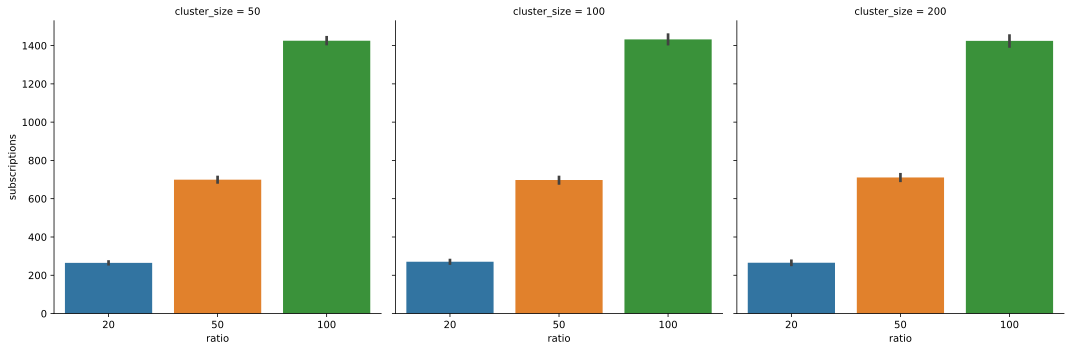

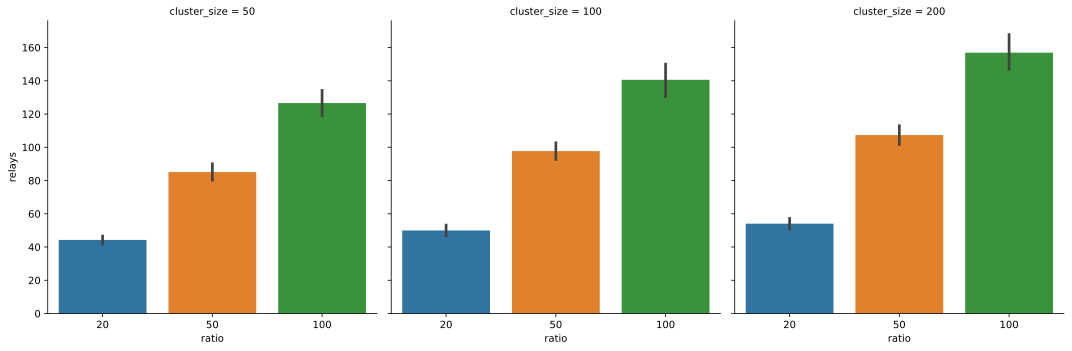

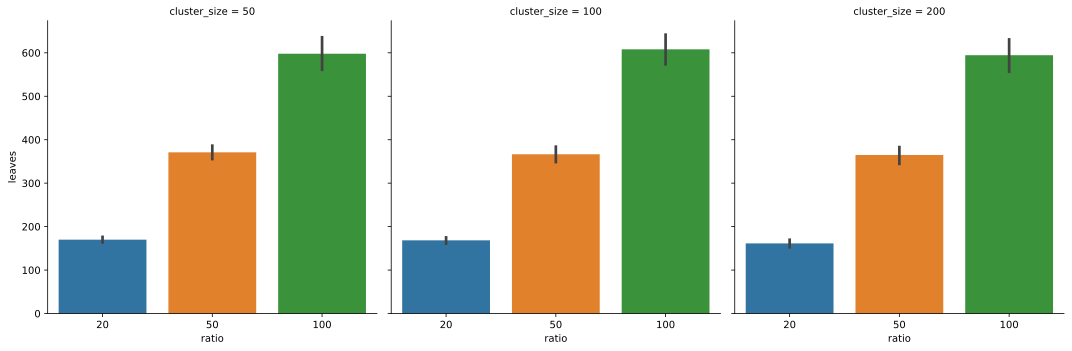

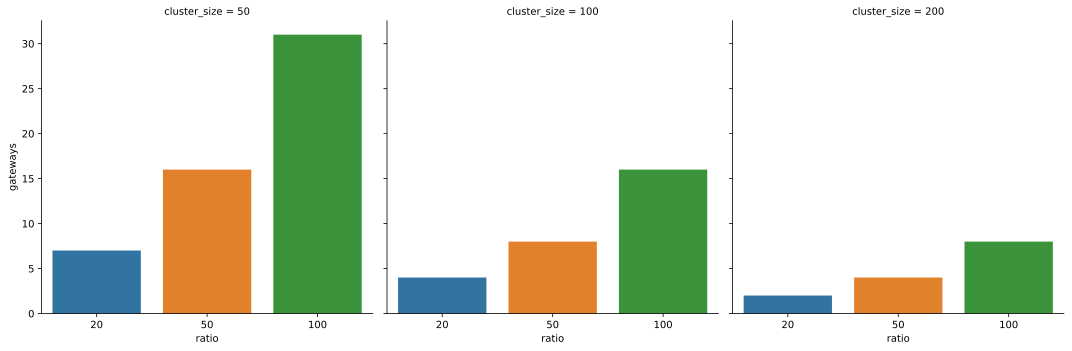

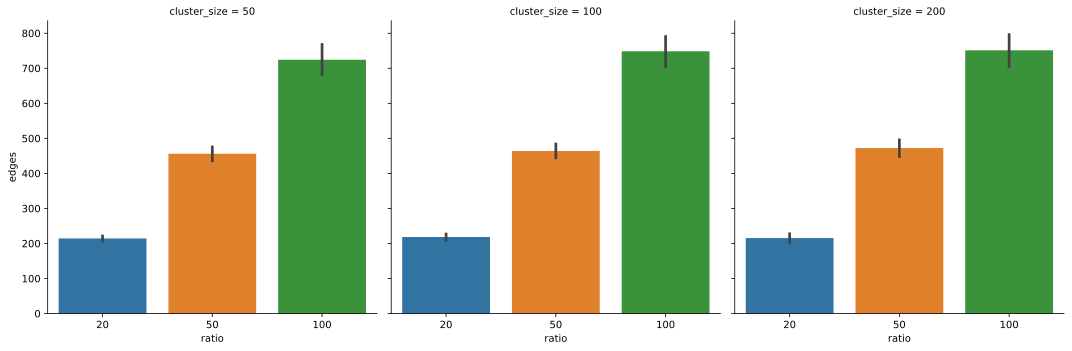

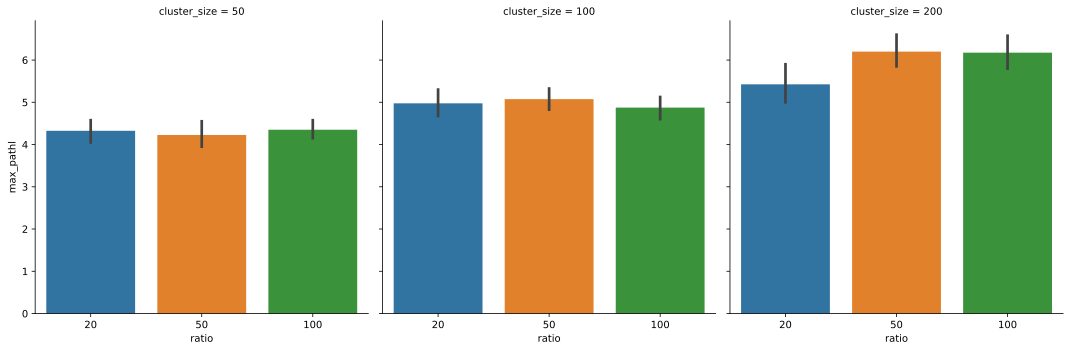

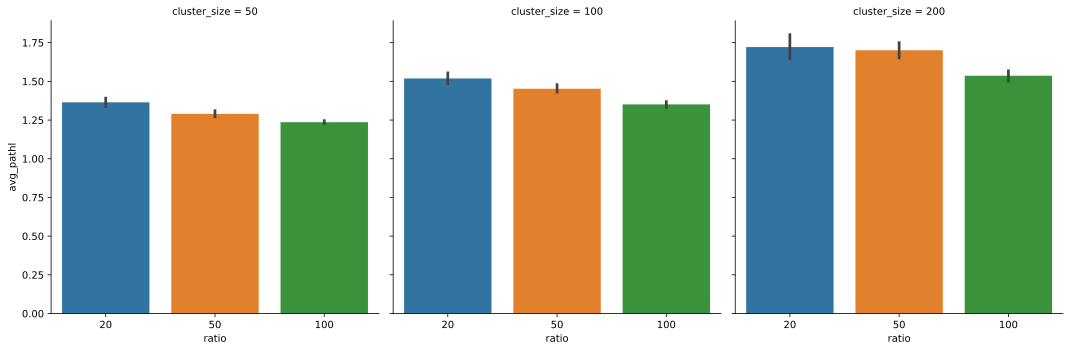

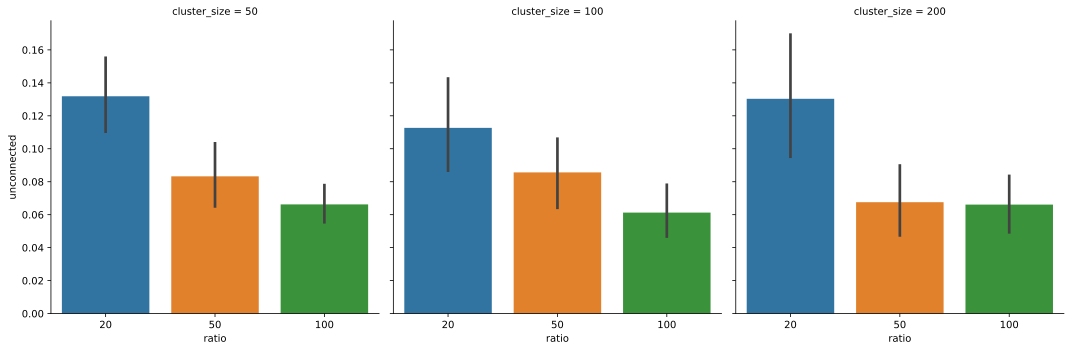

In [70]:
sns.catplot(data=df, x='ratio', y='subscriptions', col='cluster_size', kind='bar')
sns.catplot(data=df, x='ratio', y='relays', col='cluster_size', kind='bar')
sns.catplot(data=df, x='ratio', y='leaves', col='cluster_size', kind='bar')
sns.catplot(data=df, x='ratio', y='gateways', col='cluster_size', kind='bar')
sns.catplot(data=df, x='ratio', y='edges', col='cluster_size', kind='bar')
sns.catplot(data=df, x='ratio', y='max_pathl', col='cluster_size', kind='bar')
sns.catplot(data=df, x='ratio', y='avg_pathl', col='cluster_size', kind='bar')
sns.catplot(data=df, x='ratio', y='unconnected', col='cluster_size', kind='bar')



**CapEx**

In [ ]:
import requests 
from pyproj import Proj, transform
inProj = Proj(init='epsg:3003')
outProj = Proj(init='epsg:4326')

## FIX MGB for each node
max_bx = 360   #max ch capacity at mcs8
contention_ratio = 40
mgb =  max_bx/contention_ratio
capex_costs = {
    'gateway_deploy': 10000, #cost to deploy trellis + works + permits
    'gateway_router': 5000, #Imaginary cool router
    'fiber_deploy': 6000, #per km (aerial)
    'relay_router': 500, #
    'relay_deploy':  1000, # cost for trellis +  works 
    'leaf_deploy': 300, #cost for roof installation
    'leaf_radio': 100,
    'mp_radio': 200
}
mpant_bw = 120
mchan = max_bx/contention_ratio
## Calculate shortest path towards closest GW.

def calc_cost_fiber(g):
    return sum([d['length'] for s,t,d in g.edges(data=True)])*1e-3*capex_costs['fiber_deploy']

def phi(g, n):
    #Find the size of the occupied beam and see how many antennas are needed to cover it.
    thisnode = g.nodes[n]
    beams = []
    for neigh in g[n]:
        thisneigh = g.nodes[neigh]
        beam = m.degrees(m.atan2(thisneigh['x'] - thisnode['x'], thisneigh['y']-thisnode['y'])) % 360
        beams.append(beam)
    beams.sort()
    try:
        beams.append(beams[0])
    except:
        print(g[n])
    beams = np.array(beams)
    
    diff = (beams[1:] - beams[:-1] -0.0001) % 360
    width = 360 - diff.max()    
    return width

def calc_antennas(g, n, gw):
    phi_v = m.ceil(phi(g, n)/mpant_bw)
    n_paths = sum([n['paths'] for n in g[n].values()])
    if not gw:
        #Relay nodes needs double of the BW
        k=2
    else: 
        k=1
    d_v = m.ceil(n_paths*k/contention_ratio)
    return max(phi_v, d_v)

    

def calc_cost_wireless(g) -> list[float]:
    for e in g.edges():
        g.edges[e]['paths'] = 0
    
    ## For each edge where a SP pass accumulate a value
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(g, gws, weight='dist')
    for k,path in paths.items():
        n_subs = g.nodes(data=True)[k]['subscriptions']
        for i in range(len(path)-1):
            g.edges[path[i], path[i+1]]['paths'] += n_subs
                 
    ## Multiplicate the value by the BW needed for each node
    ## Calculate the cost of each edge
    for e in g.edges():
        if(g.edges[e]['paths'] == 0):
            ## For redundancy link assume a single path
            g.edges[e]['paths'] = 1
            g.edges[e]['redundant'] = 1
        else:
            g.edges[e]['redundant'] = 0
        g.edges[e]['bw'] = mgb * g.edges[e]['paths']

    for n in g.nodes():
        #If it's unconnected it does not cost
        if nx.degree(g)[n] == 0:
            g.nodes[n]['router_cost'] = 0
            g.nodes[n]['deploy'] = 0
            g.nodes[n]['fiber_cost'] = 0
            g.nodes[n]['radio_cost'] = 0
            continue
        #If it's a GW
        if g.nodes[n].get('type') == 'gateway':
            g.nodes[n]['router_cost'] = capex_costs['gateway_router'] 
            #loc = (g.nodes[n]['x'], g.nodes[n]['y'])
            #g.nodes[n]['fiber_cost' ] = capex_costs['fiber_deploy']*road_distance(fiber_points[area], loc)
            g.nodes[n]['deploy'] = capex_costs['gateway_deploy']
            g.nodes[n]['n_ant'] =  calc_antennas(g, n, True)
            #print(g.nodes[n]['n_ant'])
            g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
        else:
            g.nodes[n]['fiber_cost' ] = 0
            if g.degree()[n] == 1:
                #leaf node, no router
                g.nodes[n]['radio_cost'] = capex_costs['leaf_radio']
                g.nodes[n]['deploy'] = capex_costs['leaf_deploy']
                g.nodes[n]['router_cost'] = 0
                g.nodes[n]['n_ant'] = 1
            else:
                #relay node
                g.nodes[n]['n_ant'] = calc_antennas(g, n, False) 
                g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
                g.nodes[n]['deploy'] = capex_costs['relay_deploy']
                g.nodes[n]['router_cost'] = capex_costs['relay_router']
        
        
    router_cost = sum([g.nodes[n]['router_cost'] for n in g.nodes()])
    deploy = sum([g.nodes[n]['deploy'] for n in g.nodes()])
    radio_cost = sum([g.nodes[n]['radio_cost'] for n in g.nodes()])

    return [router_cost, deploy, radio_cost]
  

In [163]:
data = []
data_summed = []
   
for (f,w_g,f_g, n_subs) in graphs:
    graph = w_g.copy()
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    costs = calc_cost_wireless(w_g)
    costs.append(calc_cost_fiber(f_g))
   
    type_costs = ['router_cost', 'deploy', 'radio_cost', 'fiber_cost']
    total_cost = sum(costs)
    data_summed.append({'capex': total_cost/n_subs/5/12,
                        'area': area, 
                        'cluster_size': cluster_size,
                        'ratio':ratio})

    for i in range(4):
        measures = {}
        measures['cost'] = costs[i]
        measures['cost_customer'] = costs[i]/n_subs
        measures['5ymontlycostcustomer'] = costs[i]/n_subs/5/12
        measures['type_cost'] = type_costs[i]
        measures['area'] = area
        measures['ratio'] = ratio
        measures['cluster_size'] = cluster_size
        measures['time'] = time
        measures['seed'] = random_seed
        data.append(measures)
        
edf = pd.DataFrame(data)
sedf = pd.DataFrame(data_summed)

(array([0, 1, 2]), [Text(0, 0, '20'), Text(1, 0, '50'), Text(2, 0, '100')])

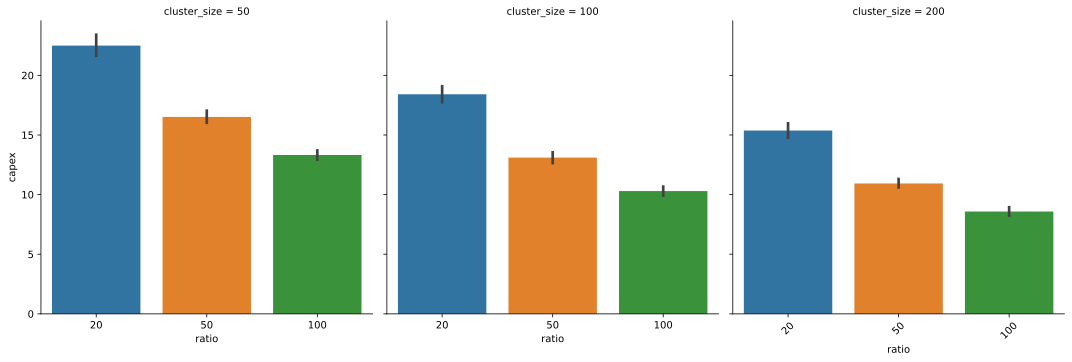

In [98]:
g = sns.catplot(data=sedf, 
            x='ratio',
            y='capex', 
            kind="bar", 
            col='cluster_size')
plt.ylabel("CapEx per customer(€)")
plt.xticks(rotation=45)

**OpEx**

In [99]:
opex_costs = {
    'bw': 1680, #Euros per year for 1Gbps  [Cerdà 2020]
    'transport_5': 23496,
    'transport_10': 31200,
    'transport_100': 55200,
    'planned_maintenance': 50, #euros per hour to repair
    'unplanned_maintenance': 200 #euros per hour to repair
}

mttf = {
    'router': 2e5, #hours [verbrugge 2006] 22y
    'radio': 1e5, #hours [random]  11yrs
}

mttr = {
    'router': 2, #hours [verbrugge 2006]
    'radio': 4, #hours
 }


def calc_opex_fiber_network(g):
    #Fiber opex
    total_bw = sum([d['subscriptions'] for n,d in g.nodes(data=True)])*mgb/1000 #Gbps of mgb
    fiber_transit = m.ceil(total_bw)*opex_costs['bw']
    if total_bw < 10:
        fiber_trasport = opex_costs['transport_10']
    elif total_bw < 100:
        fiber_trasport = opex_costs['transport_100']
    else:
        raise ValueError("Can't relay more than 100G")
    return fiber_transit, fiber_trasport

def calc_opex_maintenance(g, kind):
    #Maintenance opex
    relays = [n for n in g if  g.degree[n] > 1]
    leafs = [n for n in g if  g.degree[n] == 1]
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    p_leaf = len(leafs)/len(g)
    p_relay = len(relays)/len(g)
    p_radio_failure = (364*24)/mttf['radio']
    p_router_failure = (364*24)/mttf['router']

    n_tot_ants = sum([g.nodes[n]['n_ant'] for n in relays])
        
    gw_maintenance = p_router_failure * len(gws) * (mttr['router'] * opex_costs[kind] + capex_costs['gateway_router'])
    router_maintenance = p_router_failure  * len(relays) * (mttr['router'] * opex_costs[kind] + capex_costs['relay_router'])
    leafs_maintenance = p_leaf * p_radio_failure * len(leafs) * (mttr['radio'] * opex_costs['planned_maintenance'] + capex_costs['leaf_radio'])
    relays_maintenance = p_relay * p_radio_failure * n_tot_ants * (mttr['radio'] * opex_costs[kind] + capex_costs['mp_radio'])
    return gw_maintenance + router_maintenance + leafs_maintenance + relays_maintenance
    

In [164]:

data = []
data_summed = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    
    fiber_cost, transport_cost = calc_opex_fiber_network(w_g)
    cost_types = ['fiber', 'planed_maintenance', 'unplanned_maintenance']
    planned_maint = calc_opex_maintenance(w_g, 'planned_maintenance')
    unplanned_maint = calc_opex_maintenance(w_g, 'unplanned_maintenance')

    data.append({'fiber_cost': fiber_cost/n_subs/12,
                 'transport_cost': transport_cost/n_subs/12,
                 'unplanned_cost':  unplanned_maint/n_subs/12,
                 'area': area, 
                 'cluster_size': cluster_size,
                 'ratio':ratio})
    
    

    data_summed.append({'cost': planned_maint+fiber_cost, 
                        'cost_customer': (planned_maint+fiber_cost)/n_subs, #Cost per customer per mbps
                        'cost_customer_monthly': (planned_maint+fiber_cost)/n_subs/12,
                        'area': area, 
                        'maintennace': 'planned',
                        'cluster_size': cluster_size,
                        'ratio':ratio})
    
    # data_summed.append({'cost': (unplanned_maint+fiber_cost), 
    #                     'cost_customer': (unplanned_maint+fiber_cost)/n_subs, #Cost per customer per mbps
    #                     'cost_customer_monthly': (unplanned_maint+fiber_cost)/n_subs/12,
    #                     'area': area, 
    #                     'maintennace': 'unplanned',
    #                     'cluster_size': cluster_size,
    #                     'topo_strategy' : topo_strategy, 
    #                     'ratio':ratio})

opdf = pd.DataFrame(data)
sopdf = pd.DataFrame(data_summed)

In [ ]:
g = sns.catplot(data=sopdf, 
            x='ratio',
            y='cost_customer_monthly', 
            kind="bar",
            row='area')
plt.ylabel("Monthly OpEx per customer(€)")


**Offered Bandwidth**

In [76]:
def calc_speed(g, src, dst):
    d = g[src][dst]['dist']
    #MCS Rx table derived by Mikrotik antbox19 datasheet (some values have been interpolated)
    speed_table = [(-72, 400),
                    (-75,360),
                    (-77,300),
                    (-83,270),
                    (-86,240),
                    (-90,180),
                    (-92,120),
                    (-94,90),
                    (-95,60),
                    (-96,30)]
    pt = 30 #dBm 1W According to regulations
    gr_m = 19 #dB
    gr_d = 27 #dB
    pl = 20*m.log10(4*m.pi*d/0.0599585) #5ghz
    if g.degree()[dst] == 1: # leaf
        pr = pt + gr_d - pl
    else: #relay
        pr = pt + gr_m - pl
    
    for i in range(len(speed_table)):
        if pr>speed_table[i][0]:
            return speed_table[i][1]
    return 0


def calc_maxbw(g, p):
    bottleneck = 400
    for i in range(len(p)-1):
        speed = calc_speed(g, p[i], p[i+1])
        if speed<bottleneck:
            bottleneck=speed
    return bottleneck

def calc_minbw(g, p):
    bw_path = [max_bx*g.nodes[n]['n_ant']/sum([n['paths'] for n in g[n].values()]) for n in p]
    pass
    return min(bw_path)
        
def calc_minbw_leo(g, p):
    bw_path = []
    bw_path.append(max_bx*g.nodes[p[0]]['n_ant']/sum([n['paths'] for n in g[p[0]].values()]))
    for i in range(0, len(p)-1):
        speed = calc_speed(g, p[i], p[i+1])
        links = g[p[i]][p[i+1]]['paths']
        bw_path.append(speed/links)
    pass
    return min(bw_path)

In [174]:
mac_efficiency = 0.84

data = []
for g_id, (f,w_g,f_g, n_subs) in enumerate(graphs):
    print(g_id, len(graphs))
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)

    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(w_g, gws, weight='dist')
    speeds = []
    for src, p in paths.items():
        if src in gws:
            continue
        #min_bw = calc_minbw(w_g, p)
        min_bw_leo = calc_minbw_leo(w_g, p)
        max_bw = calc_maxbw(w_g, p)
        for s in range(w_g.nodes(data=True)[src]['subscriptions']):
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            run['node'] = src
            #run['min_bw'] = mac_efficiency*min_bw
            run['max_bw'] = mac_efficiency*max_bw
            run['min_bw_leo'] = mac_efficiency*min_bw_leo
            data.append(run)

bwdf = pd.DataFrame(data)

KeyboardInterrupt: 

**Gnuplot Graphs**

Fiber deploy over cluster size and customer ratio

In [171]:
fiber = edf[edf.type_cost=='fiber_cost']

data = fiber.groupby(['cluster_size', 'ratio'])['cost_customer'].agg(['mean', ci])
data = data.reset_index().pivot('cluster_size', 'ratio',['mean', 'ci'])
data.columns = ["_".join([a[0], str(a[1])]) for a in data.columns.to_flat_index()]
to_csv_comment(data, '/home/gabriel/WORKS/TrueNets/PhiGraph/processed/fiber_cost.csv')
data

,mean_20,mean_50,mean_100,ci_20,ci_50,ci_100
cluster_size,,,,,,
50,501.020885,261.057723,157.469500,39.588842,19.850897,13.314036
100,394.196930,211.200266,132.853883,27.664073,16.241844,10.234231
200,290.925420,152.883724,106.225006,22.182282,11.105124,8.236917


Overall cost for cluster = 200 over customer ratio

In [172]:

costs = opdf[(opdf.cluster_size==200)].groupby('ratio')[['fiber_cost', 'transport_cost', 'unplanned_cost']].agg(['mean', ci])
capex = sedf[(sedf.cluster_size==200)].groupby('ratio')['capex'].agg(['mean', ci])

costs['capex', 'mean'] = capex['mean']
costs['capex', 'ci'] = capex['ci']
costs.columns = ["_".join(a) for a in costs.columns.to_flat_index()]

costs.index = costs.index/100
to_csv_comment(costs, '/home/gabriel/WORKS/TrueNets/PhiGraph/processed/costs.csv')
costs

,fiber_cost_mean,fiber_cost_ci,transport_cost_mean,transport_cost_ci,unplanned_cost_mean,unplanned_cost_ci,capex_mean,capex_ci
ratio,,,,,,,,
0.2,1.603470,0.047878,9.926240,0.296387,1.977157,0.062289,15.484062,0.462020
0.5,1.381237,0.024375,3.664507,0.064669,1.585703,0.066420,10.615719,0.299742
1.0,1.381722,0.023002,3.242817,0.053983,1.228493,0.057006,8.136105,0.278653


Capex customer breaked up

In [173]:
rat = df[df.cluster_size == 200].groupby(['ratio'])['relays_ratio'].agg(['mean', ci])
capex = edf[(edf.cluster_size==200)].groupby(['ratio', 'type_cost'])['cost_customer'].agg(['mean', ci])
data =  capex.reset_index().pivot('ratio', 'type_cost',['mean', 'ci'])
data.columns = ["_".join(a) for a in data.columns.to_flat_index()]
data['relayratio_mean'] = rat['mean']
data['relayratio_ci'] = rat.ci
data.index = data.index/100
to_csv_comment(data, '/home/gabriel/WORKS/TrueNets/PhiGraph/processed/capex.csv')
data


,mean_deploy,mean_fiber_cost,mean_radio_cost,mean_router_cost,ci_deploy,ci_fiber_cost,ci_radio_cost,ci_router_cost,relayratio_mean,relayratio_ci
ratio,,,,,,,,,,
0.2,408.063184,290.925420,117.106167,112.948940,9.194824,22.182282,2.922163,3.919487,0.202702,0.008205
0.5,310.293920,152.883724,92.037418,81.728056,10.081587,11.105124,3.579066,3.191900,0.150686,0.006762
1.0,246.509044,106.225006,69.923256,65.508993,9.421425,8.236917,3.292841,2.453201,0.109799,0.006799


Effective bandwidth

In [72]:
data = bwdf[bwdf.cluster_size==200].groupby(['ratio'])['min_bw_leo'].agg(['mean', ci])
data.index = data.index/100
to_csv_comment(data, '/home/gabriel/WORKS/TrueNets/PhiGraph/results/processed/min_bw.csv')
data


,mean,ci
ratio,,
0.2,8.566532,0.042398
0.5,7.981324,0.014373
1.0,7.672206,0.013315


In [73]:
data = bwdf[bwdf.cluster_size==200].groupby(['ratio'])['max_bw'].agg(['mean', ci])
data.index = data.index/100

to_csv_comment(data, '/home/gabriel/WORKS/TrueNets/PhiGraph/results/processed/max_bw.csv')
data

,mean,ci
ratio,,
0.2,324.761182,0.637723
0.5,325.888982,0.376430
1.0,328.486946,0.232615


In [79]:
data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    
    # paths = nx.multi_source_dijkstra_path(g, gws)
    for src, dst in w_g.edges():
        capacity = calc_speed(w_g, src, dst)
        run = {}
        run['area'] = area
        run['cluster_size'] = cluster_size
        run['ratio'] =  ratio
        run['node'] = src
        run['distance'] = w_g[src][dst]['dist']
        run['capacity'] = capacity
        data.append(run)
            

bwdf2 = pd.DataFrame(data)

In [165]:

data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)

    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    
    # paths = nx.multi_source_dijkstra_path(g, gws)
    for n in w_g.nodes():
        if w_g.degree()[n] > 0:
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            if n in gws:
                run['type'] = 'gw'
            elif w_g.degree()[n]==1:
                run['type'] = 'leaf'
            else:
                run['type'] = 'relay'
            run['antennae'] =  calc_antennas(w_g, n, n in gws)
            run['degree'] = w_g.degree()[n]
            data.append(run)
            

df3 = pd.DataFrame(data)

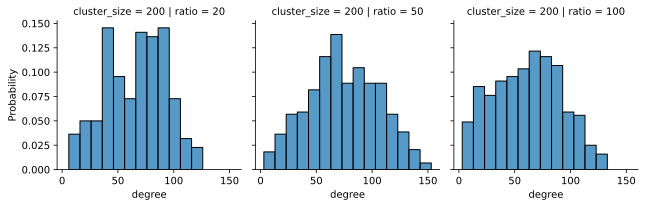

In [170]:
g = sns.FacetGrid(data=df3[(df3.type=='gw') &(df3.cluster_size==200)], col='ratio', row='cluster_size')
g.map_dataframe(sns.histplot, x='degree', stat='probability', cumulative=False, binwidth=10)
#sns.histplot(data=df3[df3.type=='gw'], x='degree', stat='probability', cumulative=True)

12

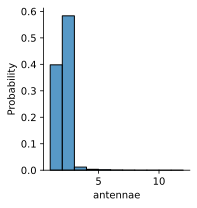

In [169]:
g = sns.FacetGrid(data=df3[(df3.type=='relay')])

g.map_dataframe(sns.histplot, x='antennae', stat='probability', binwidth=1)
df3[df3.type=='relay']['antennae'].max()

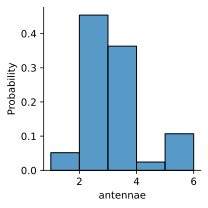

In [168]:
g = sns.FacetGrid(data=df3[(df3.type=='gw')])
g.map_dataframe(sns.histplot, x='antennae', stat='probability', binwidth=1)

Text(0, 0.5, '$n_a(n)$')

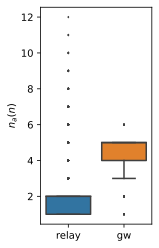

In [167]:

d= df3[(df3.cluster_size == 200) &(df3.type != 'leaf')]#.groupby(['type'])['antennae'].quantile([0.1,0.9])
plt.figure(figsize=(2,4))
sns.boxplot(x="type", y="antennae", data=d, whis=[10, 90], fliersize=1)
plt.xlabel("")
plt.ylabel("$n_a(n)$")


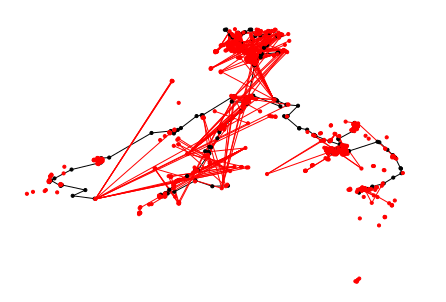

In [93]:
g = graphs[100]
pos = {n:(d['x'],d['y']) for n, d in g[2].nodes(data=True)}
nx.draw(g[2], pos=pos, node_size=10, node_color='black', edge_color='black')
pos = {n:(d['x'],d['y']) for n, d in g[1].nodes(data=True)}
nx.draw(g[1], pos=pos, node_size=10, node_color='red', edge_color='red')

In [166]:
df3.area.unique()

array(['sambuca pistoiese', 'villa basilica', 'borgo a mozzano',
       'castel del piano', 'santa fiora', 'magliano in toscana',
       'porcari', 'roccalbegna', 'fauglia', 'stazzema', 'semproniano'],
      dtype=object)